# 00 Attempt at post processing

Based on tools and scripts provided by Michael Brazell and Lawrence Cheung

Utilize the abl_stats class to carry out post processing

See https://github.com/Exawind/amr-wind-frontend/blob/main/docs/casestudies/SWIFT/Postprocessing.ipynb

In [1]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import netCDF4 as ncdf
import pandas as pd
import os

In [2]:
from moa_python.abl_stats import Abl_stats

## Parameters

In [3]:
case_folder = '/scratch/pfleming/c2c/000_paul_tries_precursor'
post_processing_file = 'post_processing/abl_statistics00000.nc'

In [4]:
full_filename = os.path.join(case_folder,post_processing_file )

## Load the data

In [6]:
abl = Abl_stats([full_filename])

Object is composed of 1 and time runs from 0.5 to 22000.0
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: AMR-Wind ABL statistics output
    version: 642185772586
    created_on: Thu Dec  8 16:51:43 2022

    dimensions(sizes): num_time_steps(44000), ndim(3)
    variables(dimensions): float64 time(num_time_steps), float64 Q(num_time_steps), float64 Tsurf(num_time_steps), float64 ustar(num_time_steps), float64 wstar(num_time_steps), float64 L(num_time_steps), float64 zi(num_time_steps), float64 abl_forcing_x(num_time_steps), float64 abl_forcing_y(num_time_steps)
    groups: mean_profiles


## Visualize vertical velocity

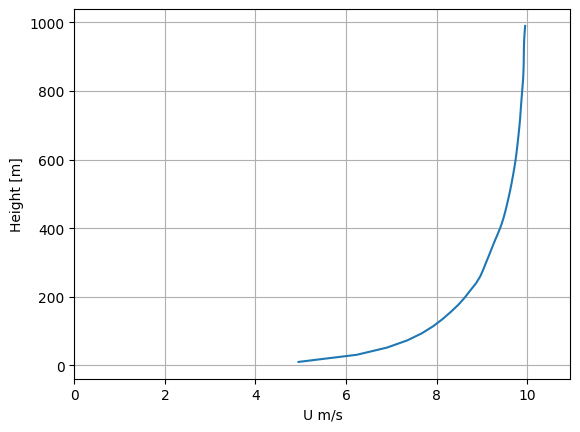

In [7]:
abl.plot_vert_vel_profile(10000,20000) # Show vertical velocity averaged 10000-20000 s

In [ ]:

abs.get_time_series_at_height('u', 1000)

## Define a class to help organize this

In [59]:
class Abl_stats:
    
    def __init__(self, filenames):
        
        # If only one filename passed in
        # Convert to list for consistency
        if not isinstance(filenames, (list, tuple, np.ndarray)):
            filenames = [filenames]
        
        self.Nfiles = len(filenames)
        
        # Load the datasets
        self.dataset_list = []
        for filename in filenames:
            self.dataset_list.append(ncdf.Dataset(filename))
        
        # Read time
        self.time = self.get_variable_from_abl_stats('time')
        self.num_time_steps = len(self.time)
        
        # Save the mean profiles
        self.mean_profiles = self.get_group_from_abl_stats('mean_profiles')
        
        # Save the z-levels
        self.z = self.get_data_from_mean_profiles('h')
        
        # Print a quick summar
        self.summary()
        
    def summary(self):
        
        print(f"Object is composed of {self.Nfiles} and time runs from {self.time[0]} to {self.time[-1]}")
        print(self.dataset_list[0])
        
    def get_variable_from_abl_stats(self, variablename):
        """
        Reads requested variable from dataset_list and puts data into arrays
        
        Args in:
            variable (str): the name of the group.

        Args out:
            data (class 'netCDF4._netCDF4.Group'): the requested group(s)
        """

        data = np.array([])
        for i in range(self.Nfiles):
            data = np.append(data,self.dataset_list[i].variables[variablename])

        return data
        
    def get_group_from_abl_stats(self, groupname):
        """
        Reads requested data from dataset_list and puts data into arrays
        
        Args in:
            variable (str): the name of the group.

        Args out:
            data (class 'netCDF4._netCDF4.Group'): the requested group(s)
        """

        data = np.array([])
        for i in range(self.Nfiles):
            data = np.append(data,self.dataset_list[i].groups[groupname])

        return data
    
    
    def get_data_from_group(self, 
        group,
        variable
    ):
        """
        Reads requested data from within a group and returns array

        Args in:
            group (class 'netCDF4._netCDF4.Group' or class 'numpy.ndarray'): 
                group or array of groups as obtained from .nc-file(s).
            variable (str): the required variable to be extracted from group.

        Args out:
            data (class 'numpy.ndarray'): the requested variable
        """

        for i in range(self.Nfiles):
            
            variablenames = list(group[i].variables.keys())

            if variable in variablenames:
                if i == 0:
                    data = np.array(np.array(group[i].variables[variable]))
                else:
                    data = np.append(data,np.array(group[i].variables[variable]),axis=0)
            else:
                raise ValueError(f'The specified variable was not found in the given group. \n Available variables: {variablenames} \n Requested variable: {variable}')


        return data
    
    def get_data_from_mean_profiles(self, variable
    ):
        
        """
        Reads requested data from mean profile and returns array

        Args in:
            group (class 'netCDF4._netCDF4.Group' or class 'numpy.ndarray'): 
                group or array of groups as obtained from .nc-file(s).
            variable (str): the required variable to be extracted from group.

        Args out:
            data (class 'numpy.ndarray'): the requested variable
        """
        return self.get_data_from_group(self.mean_profiles, variable)
    
    def time_average_data(self, x, t_min=None, t_max=None):
        
        """
        Averages the data (x) over time period [t_min, t_max)

        Args in:
            x (class 'numpy.ndarray'): 
                an np.array of length = self.num_time_steps
            t_min (float): time to start averaging (inclusive)
                if None, defaults to self.time[0]
            t_max (float): time to stop averaging (non-inclusive)
                if None, defaults to self.time[-1]

        Args out:
            data (class 'numpy.ndarray'): time averaged data
        """
        
        # Set defaults
        if t_min is None:
            t_min = self.time[0]
        if t_max is None:
            t_max = self.time[-1]
            
        # Check for out of bounds
        if t_min < self.time[0]:
            raise ValueError(f'T_min ({t_min}) is less than the minimum time ({self.time[0]})')
        if t_max > self.time[-1]:
            raise ValueError(f'T_max ({t_max}) is greater than the maximum time ({self.time[-1]})')
            
        # Find time indices within time
        t_min_idx = np.argmax(self.time >= t_min)
        t_max_idx = np.argmax(self.time >= t_max)
        
        # Perform the average and return
        return np.mean(x[t_min_idx:t_max_idx],axis=0)
    
    def plot_vert_vel_profile(self, t_min=None, t_max=None, ax=None):
        """
        Plot the vertical velocity profile over an averaging
        period of [t_min, t_max]

        Args in:
            t_min (float): time to start averaging (inclusive)
            t_max (float): time to stop averaging (non-inclusive)
            ax (:py:class:'matplotlib.pyplot.axes', optional):
                figure axes. Defaults to None.
        """
        if ax is None:
            fig, ax = plt.subplots()
            
        u = self.get_data_from_mean_profiles('u')
        u_avg = self.time_average_data(u, t_min, t_max)
        
        ax.plot(u_avg, self.z)
        ax.set_xlabel("U m/s")
        ax.set_ylabel("Height [m]")
        xmax = (np.max(u_avg)+1)
        ax.set_xlim([0, xmax])
        ax.grid(True)
        
    def get_time_series_at_height(self, variable, height):
        """
        Return the values of a variable within the mean_profiles for a specific height

        Args in:
            variable (str): the required variable to be extracted from group.
            height (float): the height to extract, if not a value of self.z, will use nearest

        Args out:
            data (class 'numpy.ndarray'): the requested variable
        """
        
        # Identify nearest height
        h_idx = np.argmin(np.abs(self.z - height))
        print(f'Nearest height to {height} is {self.z[h_idx]}')
        
        # Get the data
        x = self.get_data_from_mean_profiles(variable)
        
        # Return at height
        return np.squeeze(x[:,h_idx])
    
        
        

    
        


Object is composed of 1 and time runs from 0.5 to 22000.0
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: AMR-Wind ABL statistics output
    version: 642185772586
    created_on: Thu Dec  8 16:51:43 2022

    dimensions(sizes): num_time_steps(44000), ndim(3)
    variables(dimensions): float64 time(num_time_steps), float64 Q(num_time_steps), float64 Tsurf(num_time_steps), float64 ustar(num_time_steps), float64 wstar(num_time_steps), float64 L(num_time_steps), float64 zi(num_time_steps), float64 abl_forcing_x(num_time_steps), float64 abl_forcing_y(num_time_steps)
    groups: mean_profiles
Nearest height to 1000 is 989.5833333333333


array([10.        , 10.        , 10.        , ...,  9.78619061,
        9.78619943,  9.78620834])

True

## Load the thing

In [ ]:
mpp.get_group_from_abl_stats(case_folder,post_processing_file,groupname)

## Load data

New to this library so just flagging

https://unidata.github.io/netcdf4-python/

In [5]:
d1 = ncdf.Dataset(os.path.join(case_folder,post_processing_file ))

In [6]:
print(d1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: AMR-Wind ABL statistics output
    version: 642185772586
    created_on: Thu Dec  8 16:51:43 2022

    dimensions(sizes): num_time_steps(44000), ndim(3)
    variables(dimensions): float64 time(num_time_steps), float64 Q(num_time_steps), float64 Tsurf(num_time_steps), float64 ustar(num_time_steps), float64 wstar(num_time_steps), float64 L(num_time_steps), float64 zi(num_time_steps), float64 abl_forcing_x(num_time_steps), float64 abl_forcing_y(num_time_steps)
    groups: mean_profiles


In [7]:
dir(d1)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__orthogonal_indexing__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_close',
 '_close_mem',
 '_enddef',
 '_getname',
 '_grpid',
 '_isopen',
 '_ncstring_attrs__',
 '_redef',
 'close',
 'cmptypes',
 'createCompoundType',
 'createDimension',
 'createEnumType',
 'createGroup',
 'createVLType',
 'createVariable',
 'created_on',
 'data_model',
 'delncattr',
 'dimensions',
 'disk_format',
 'enumtypes',
 'file_format',
 'filepath',
 'fromcdl',
 'get_variables_by_attributes',
 'getncattr',
 'groups',
 'has_blosc_filter',
 'has_bzip2_filter',
 'has_szip_filter',
 'has_zstd_filter',
 'isopen',
 'keepweakref',
 'name',
 'ncattrs',
 'parent',
 'path',
 'rena

## Try unpacking the dataset

In [8]:
d1.groups

{'mean_profiles': <class 'netCDF4._netCDF4.Group'>
 group /mean_profiles:
     dimensions(sizes): nlevels(48)
     variables(dimensions): float64 h(nlevels), float64 u(num_time_steps, nlevels), float64 v(num_time_steps, nlevels), float64 w(num_time_steps, nlevels), float64 hvelmag(num_time_steps, nlevels), float64 theta(num_time_steps, nlevels), float64 mueff(num_time_steps, nlevels), float64 theta'theta'_r(num_time_steps, nlevels), float64 u'theta'_r(num_time_steps, nlevels), float64 v'theta'_r(num_time_steps, nlevels), float64 w'theta'_r(num_time_steps, nlevels), float64 u'u'_r(num_time_steps, nlevels), float64 u'v'_r(num_time_steps, nlevels), float64 u'w'_r(num_time_steps, nlevels), float64 v'v'_r(num_time_steps, nlevels), float64 v'w'_r(num_time_steps, nlevels), float64 w'w'_r(num_time_steps, nlevels), float64 u'u'u'_r(num_time_steps, nlevels), float64 v'v'v'_r(num_time_steps, nlevels), float64 w'w'w'_r(num_time_steps, nlevels), float64 u'theta'_sfs(num_time_steps, nlevels), float6

In [9]:
g1 = d1.groups["mean_profiles"]

In [10]:
print(g1)

<class 'netCDF4._netCDF4.Group'>
group /mean_profiles:
    dimensions(sizes): nlevels(48)
    variables(dimensions): float64 h(nlevels), float64 u(num_time_steps, nlevels), float64 v(num_time_steps, nlevels), float64 w(num_time_steps, nlevels), float64 hvelmag(num_time_steps, nlevels), float64 theta(num_time_steps, nlevels), float64 mueff(num_time_steps, nlevels), float64 theta'theta'_r(num_time_steps, nlevels), float64 u'theta'_r(num_time_steps, nlevels), float64 v'theta'_r(num_time_steps, nlevels), float64 w'theta'_r(num_time_steps, nlevels), float64 u'u'_r(num_time_steps, nlevels), float64 u'v'_r(num_time_steps, nlevels), float64 u'w'_r(num_time_steps, nlevels), float64 v'v'_r(num_time_steps, nlevels), float64 v'w'_r(num_time_steps, nlevels), float64 w'w'_r(num_time_steps, nlevels), float64 u'u'u'_r(num_time_steps, nlevels), float64 v'v'v'_r(num_time_steps, nlevels), float64 w'w'w'_r(num_time_steps, nlevels), float64 u'theta'_sfs(num_time_steps, nlevels), float64 v'theta'_sfs(num_ti

Need to spend some time learning how all of this works so we can make a really generic useful analysis notebook here

## Based on post_process.py, show a mean u profile

In [11]:
u1 = g1.variables['u']
u1

<class 'netCDF4._netCDF4.Variable'>
float64 u(num_time_steps, nlevels)
path = /mean_profiles
unlimited dimensions: num_time_steps
current shape = (44000, 48)
filling on, default _FillValue of 9.969209968386869e+36 used

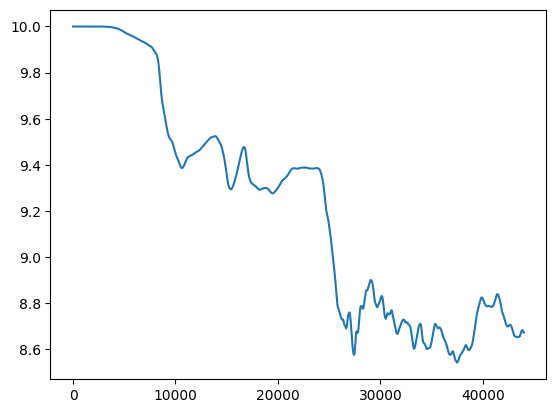

In [12]:
plt.plot(u1[:,11])

In [13]:
# avg 5-6 hrs, 5hrs -> 3600*5*2 = 36000 timesteps
# todo, there is a time variable in netcdf file that could be used to find the correct time steps
uavg1 = np.average(u1[35999:43199],axis=0)
uavg1

masked_array(data=[5.34856835, 6.68052662, 7.29131385, 7.67104879,
                   7.91528557, 8.09949017, 8.25480696, 8.37823064,
                   8.47984537, 8.56527746, 8.634128  , 8.69071863,
                   8.73653257, 8.77739067, 8.81246233, 8.8506775 ,
                   8.89714393, 8.95087078, 9.00739646, 9.0702856 ,
                   9.13460859, 9.19436285, 9.24516056, 9.29292647,
                   9.33899929, 9.38378692, 9.42566154, 9.46611416,
                   9.50226653, 9.53012661, 9.55242054, 9.57212889,
                   9.58924216, 9.6064368 , 9.62456155, 9.64125683,
                   9.65729803, 9.67634062, 9.69840964, 9.72074242,
                   9.73727211, 9.74450036, 9.74541967, 9.74851938,
                   9.75392839, 9.7668381 , 9.78882567, 9.8166415 ],
             mask=False,
       fill_value=1e+20)

In [14]:
z = g1.variables["h"]
z = np.array(z)

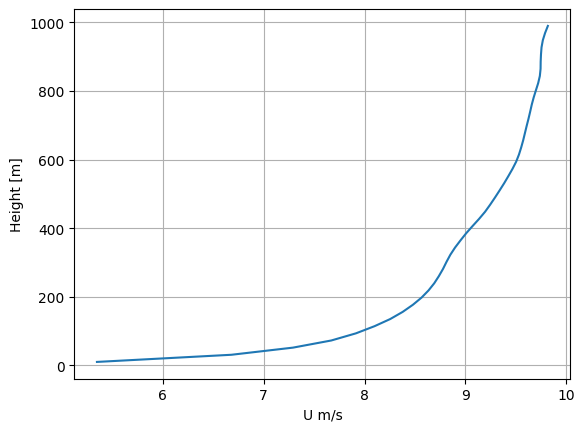

In [15]:
fig, ax = plt.subplots()
ax.plot(uavg1,z)
ax.set_xlabel("U m/s")
ax.set_ylabel("Height [m]")
ax.grid(True)

## Try new module function

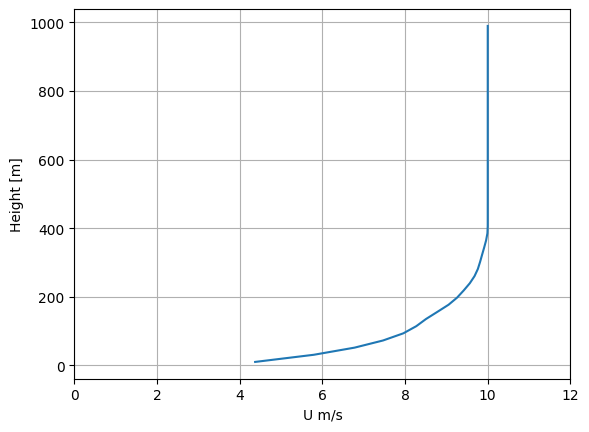

In [20]:
mpp.plot_vert_vel_profile(os.path.join(case_folder,post_processing_file ),[2000,10000] )